#File for analysing results of file "registration_and_analysis.py"

- Display of distribution of voted circle and corresponding likelihood
- Display of registration at the end

Data used: analysis/i.xlsx : data of all cylinder tested, with direction, radius, center, likelihood, etc.
analysis/cylinder_comparison.xlsx : resulting chosen cylinder at the end of the algorithm

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

RESULT_PATH = Path("/home/renaud/Desktop/Data/outputs/analysis")

volunteer_index = [i for i in range(16)]
left_index = [2 * i for i in range(16)]
right_index = [2 * i + 1 for i in range(16)]

In [2]:
data_fitting_left = [pd.read_excel(str(RESULT_PATH / f"{i}.xlsx"), usecols='B:G',
                                   dtype={'d': np.ndarray, 'e': np.ndarray}) for i in left_index]
data_fitting_right = [pd.read_excel(str(RESULT_PATH / f"{i}.xlsx"), usecols='B:G',
                                    dtype={'d': np.ndarray, 'e': np.ndarray}) for i in right_index]

data_fitting_ref = [pd.read_excel(str(RESULT_PATH / "reference" / f"{i}.xlsx"), usecols='B:G',
                                  dtype={'d': np.ndarray, 'e': np.ndarray}) for i in volunteer_index]

In [3]:
print(data_fitting_left[0].info())
print(data_fitting_left[0].describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   likelihood    297 non-null    float64
 1   radius        297 non-null    float64
 2   centers       297 non-null    object 
 3   direction     297 non-null    object 
 4   id_direction  297 non-null    int64  
 5   id_iteration  297 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 14.0+ KB
None
       likelihood         radius  id_direction  id_iteration
count  297.000000     297.000000    297.000000    297.000000
mean     0.063583     822.823131      0.663300      1.154882
std      0.058414   13608.169866      0.749617      0.689877
min      0.000000       3.391402      0.000000      0.000000
25%      0.000036      11.411086      0.000000      1.000000
50%      0.055265      14.374356      0.000000      1.000000
75%      0.119102      19.300905      1.000000      2.000

In [4]:
data_left = pd.concat(data_fitting_left, keys=volunteer_index, names=["volunteer", "second"])
data_right = pd.concat(data_fitting_right, keys=volunteer_index, names=["volunteer", "second"])
data_ref = pd.concat(data_fitting_ref, keys=volunteer_index, names=["volunteer", "second"])

In [5]:
data_left['likelihood2'] = data_left["likelihood"] * np.exp(0.5 * (data_left['radius'] - 10) ** 2 / 4 ** 2)
data_right['likelihood2'] = data_right["likelihood"] * np.exp(0.5 * (data_right['radius'] - 10) ** 2 / 4 ** 2)
data_ref['likelihood2'] = data_ref["likelihood"] * np.exp(0.5 * (data_ref['radius'] - 10) ** 2 / 4 ** 2)

/home/renaud/PycharmProjects/TUM/Registration/env/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/renaud/PycharmProjects/TUM/Registration/env/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/renaud/PycharmProjects/TUM/Registration/env/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


'\n1 - L_prior * L_2 * L_compatibility\n'

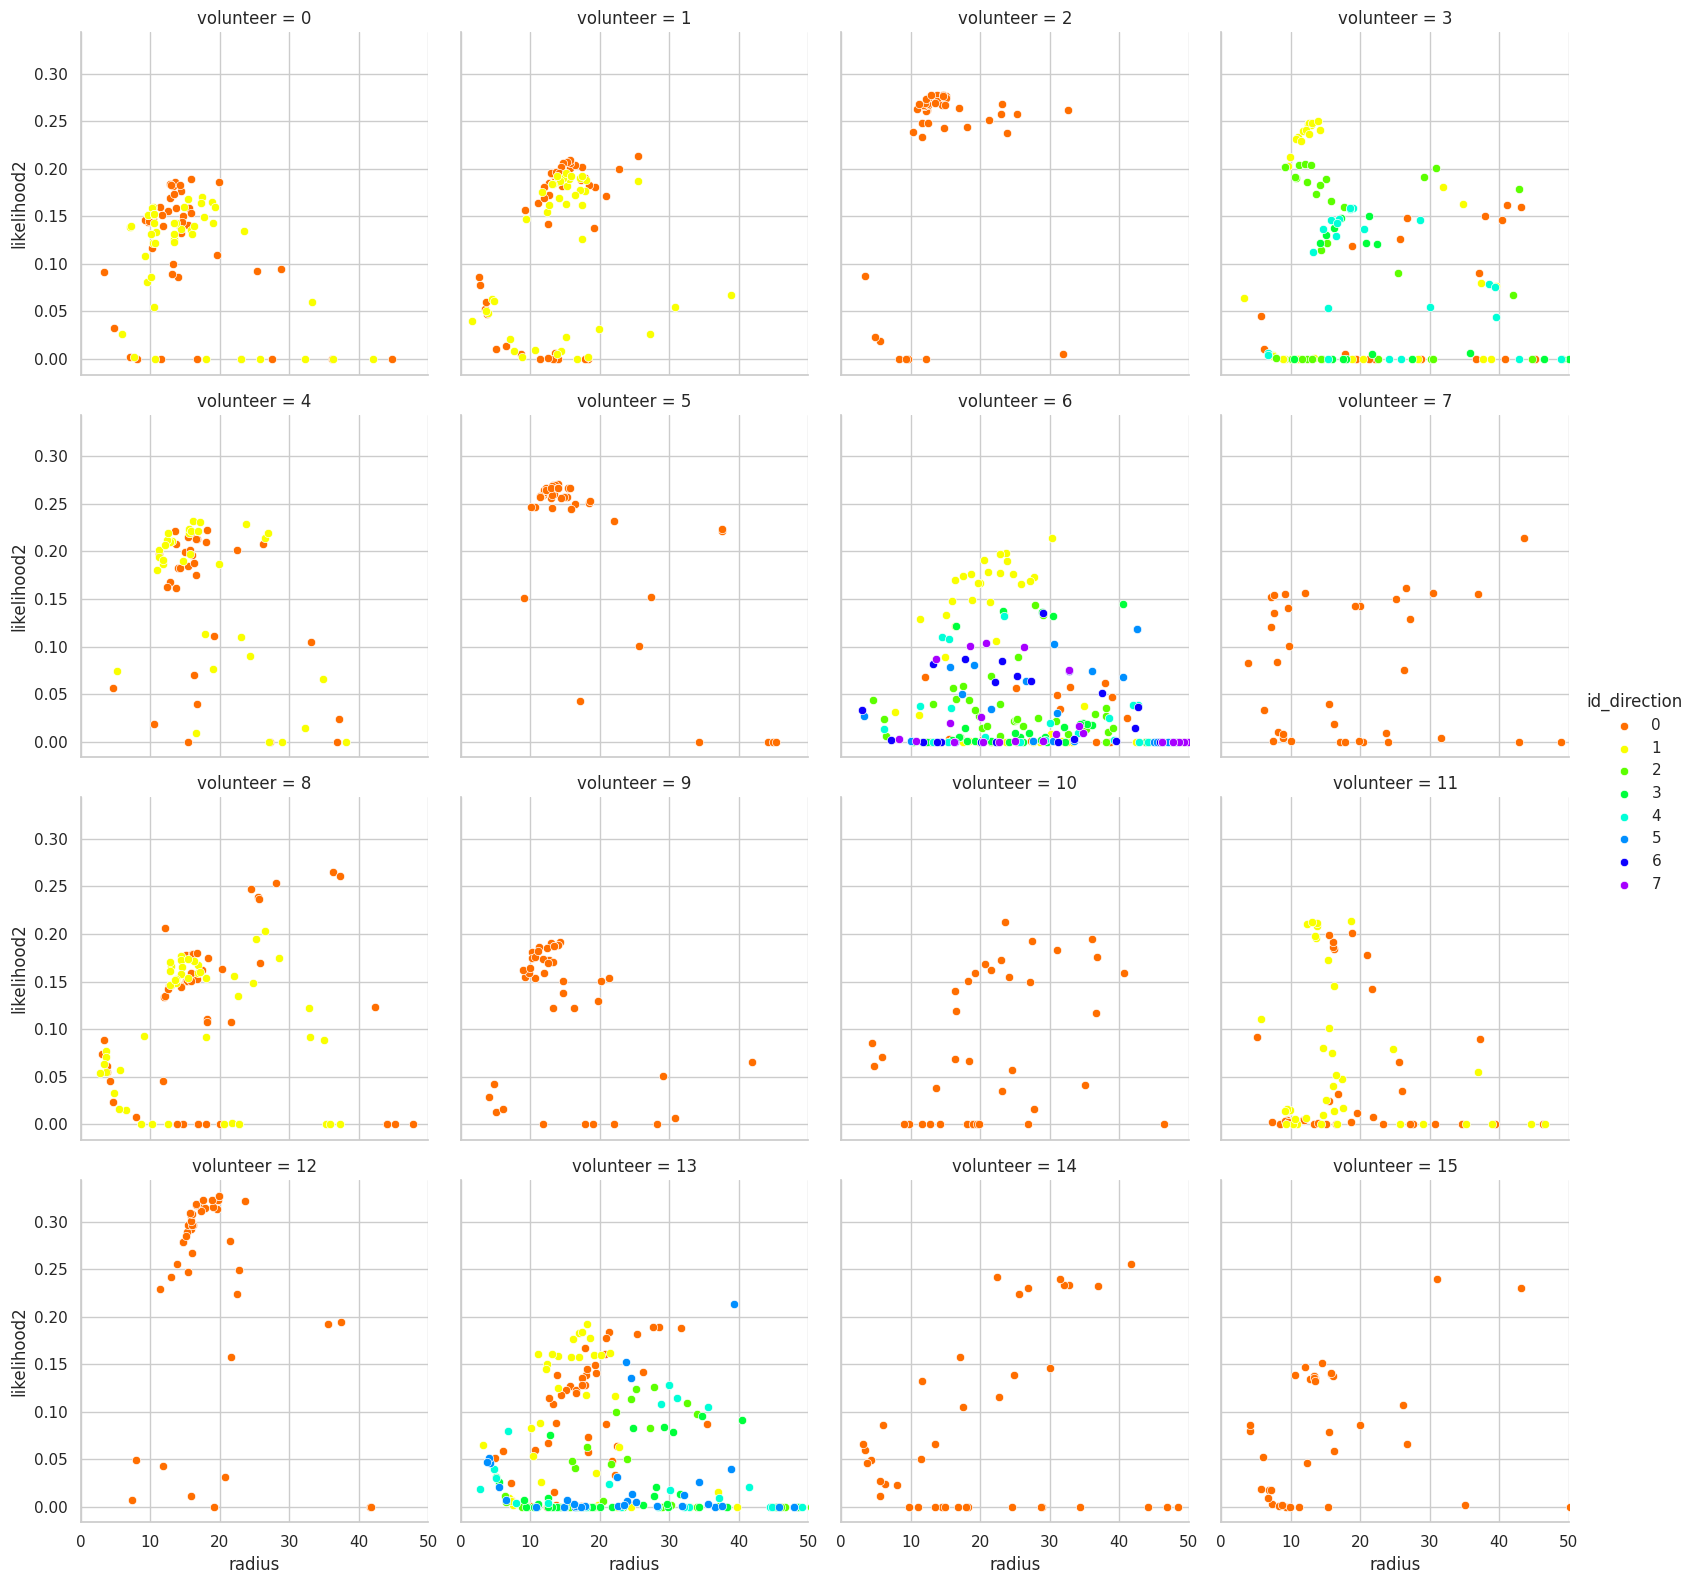

In [15]:
data_left_temp = data_left.reset_index()
sns.set_theme(style="whitegrid")
g = sns.FacetGrid(data_left_temp[data_left_temp["id_iteration"]==2.], col="volunteer", col_wrap=4, height=4, xlim=(0, 50), hue='id_direction',
                  palette='gist_rainbow')
g.map(sns.scatterplot, "radius", "likelihood2")
g.add_legend()
"""
1 - L_prior * L_2 * L_compatibility
"""


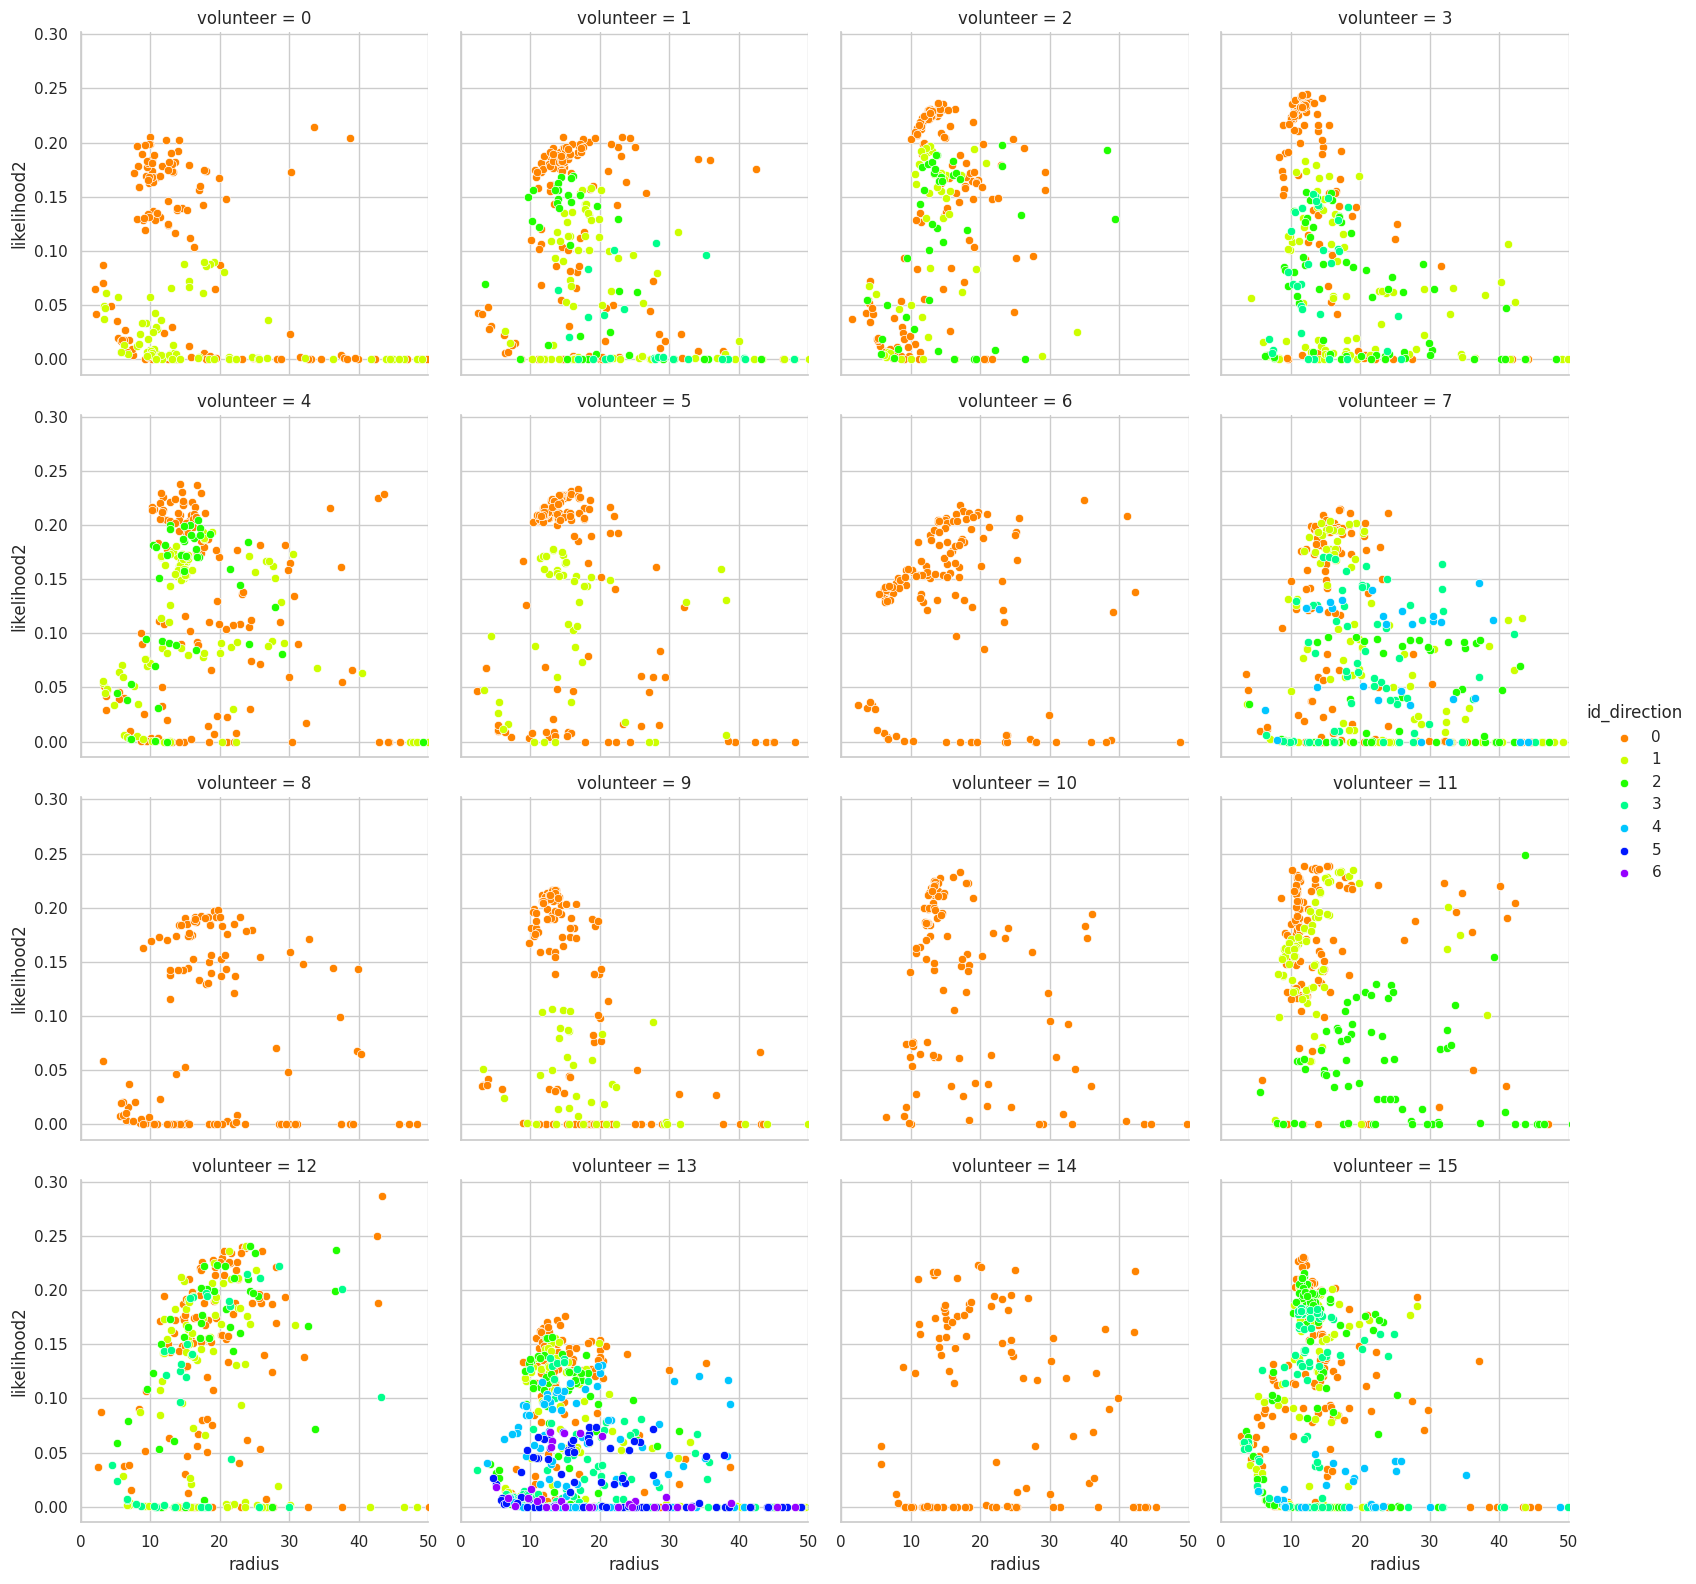

In [14]:
sns.set_theme(style="whitegrid")
g = sns.FacetGrid(data_right.reset_index(), col="volunteer", col_wrap=4, height=4, xlim=(0,
                                                                                         50), hue='id_direction',
                  palette='gist_rainbow')
g.map(sns.scatterplot, "radius", "likelihood2")
g.add_legend()

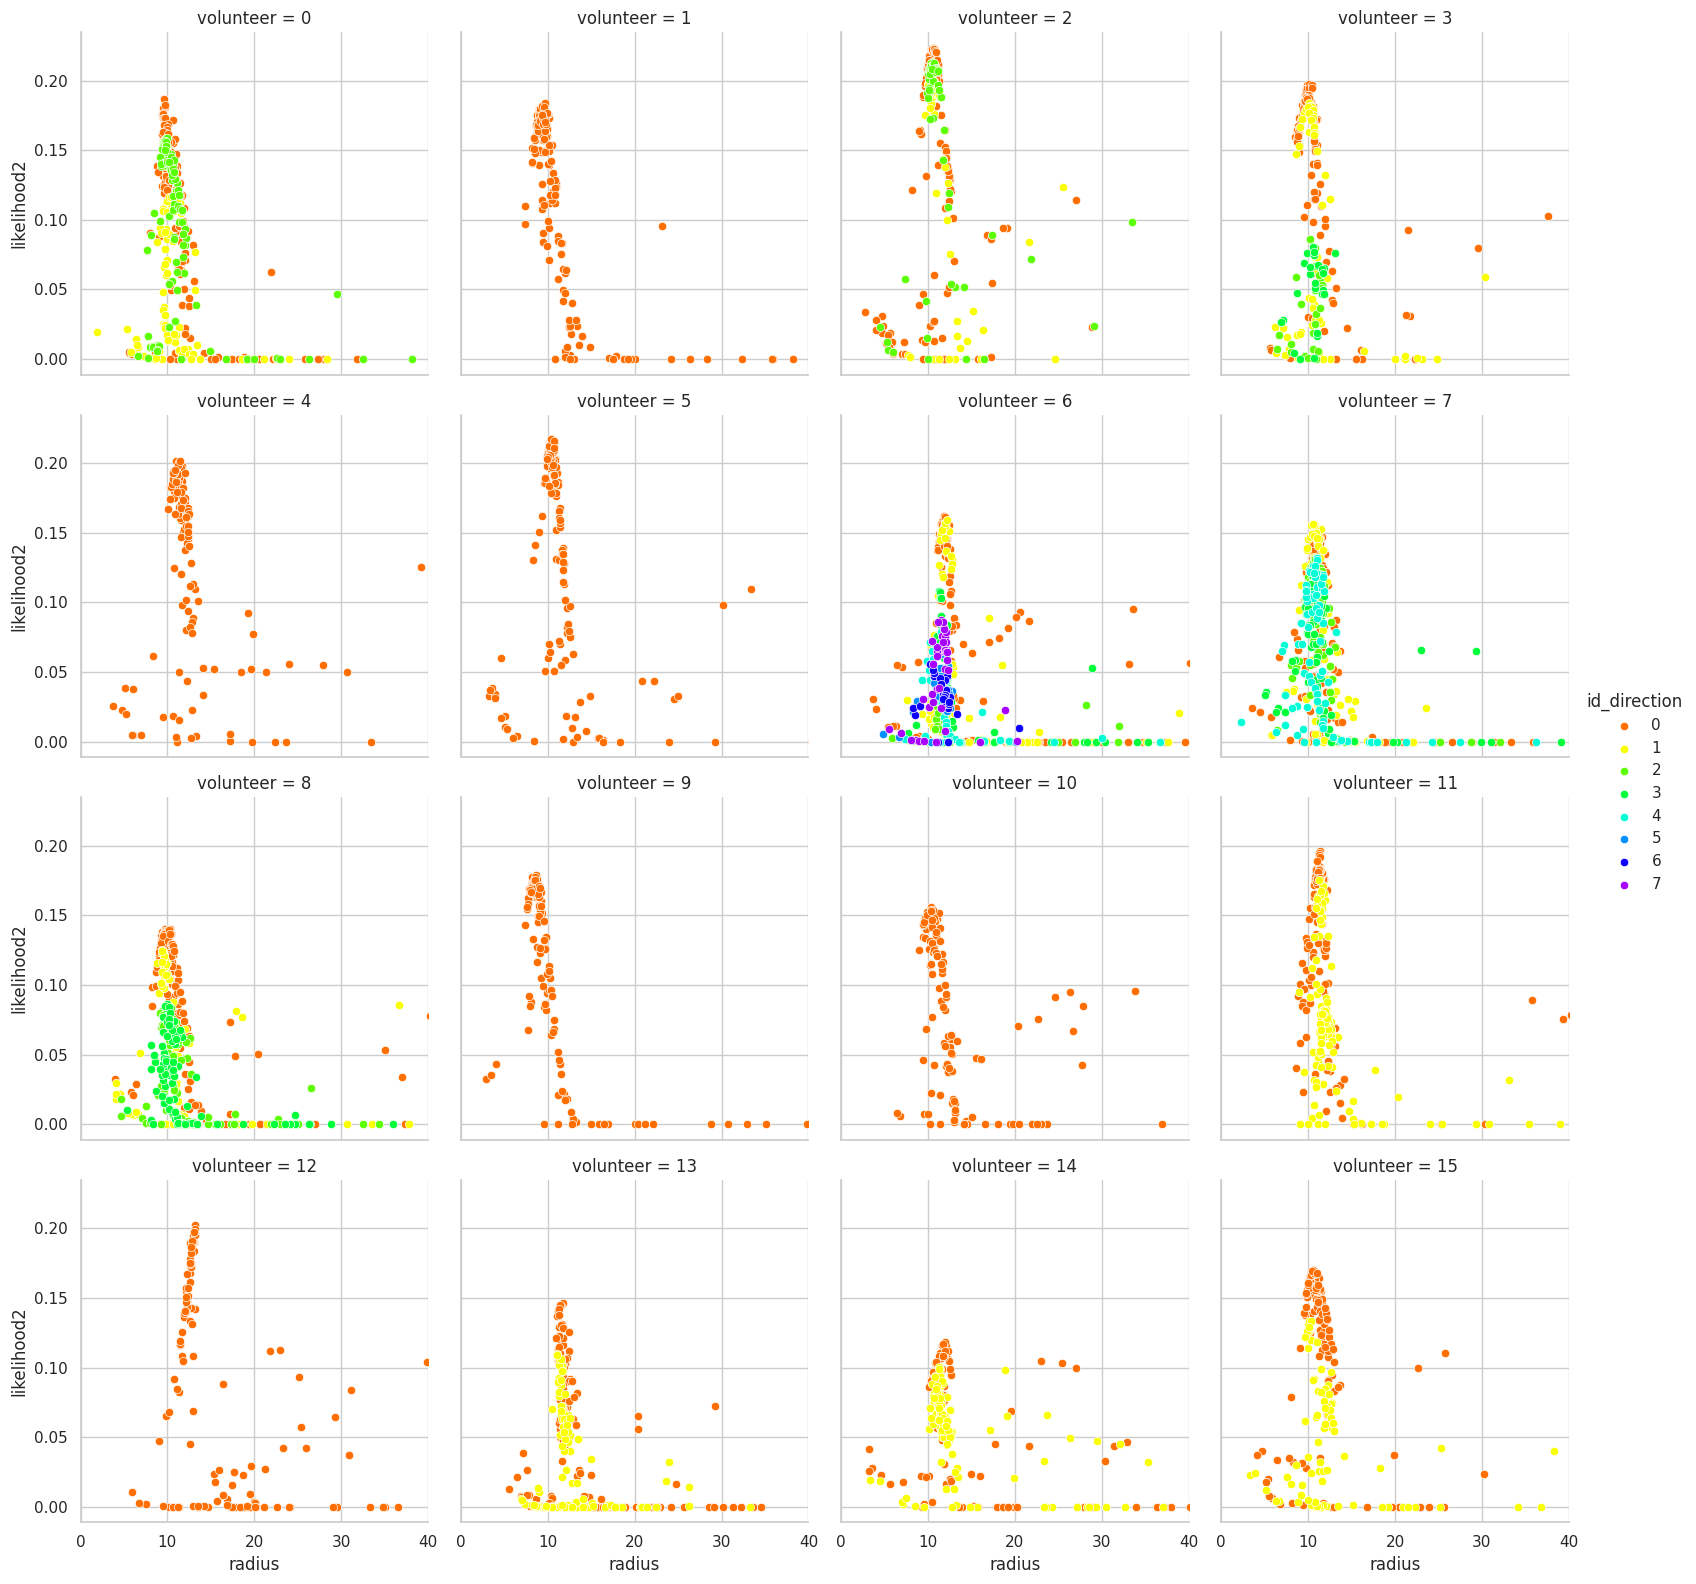

In [8]:
sns.set_theme(style="whitegrid")
g = sns.FacetGrid(data_ref.reset_index(), col="volunteer", col_wrap=4, height=4, xlim=(0, 40), hue='id_direction',
                  palette='gist_rainbow')
g.map(sns.scatterplot, "radius", "likelihood2")
g.add_legend()

In [9]:
def convert_object_to_array(string_direction):
    li = string_direction[1:][:-1].split(" ")
    while '' in li:
        li.remove('')
    return np.array([float(i) for i  in li], dtype=np.float32)


def convert_array(object_array):
    n = len(object_array)
    new_list = []
    for i in range(n):
        new_list.append(convert_object_to_array(object_array[i]))
    return np.array(new_list)

In [10]:
def extract_max_likely(data):
    multi_index = data.reset_index().set_index(["volunteer", "id_iteration", "id_direction", "second"])
    result = []
    index_levels = multi_index.index.levels
    for volunteer in index_levels[0]:
        index_iteration = multi_index.loc[volunteer].index.get_level_values(0).unique()
        for iteration in index_iteration:
            index_directions = multi_index.loc[volunteer, iteration].index.get_level_values(0).unique()
            for i_direction in index_directions:
                i_max_l = multi_index.loc[volunteer, iteration, i_direction]['likelihood'].argmax()
                likelihood, radius, centers, direction = multi_index.loc[volunteer, iteration, i_direction].iloc[
                                                             i_max_l][:4]
                result.append([volunteer, iteration, i_direction, likelihood, radius, convert_object_to_array(centers),
                               convert_object_to_array(direction)])

    return pd.DataFrame(result, columns=['volunteer', 'iteration', 'i_direction', 'likelihood', 'radius', 'centers',
                                         'direction'])

In [11]:
max_likely_left = extract_max_likely(data_left)
max_likely_right = extract_max_likely(data_right)
max_likely_ref = extract_max_likely(data_ref)

In [12]:
elected_left = max_likely_left[(max_likely_left['i_direction'] == 0) * (max_likely_left['iteration'] > 1.)]
elected_right = max_likely_right[(max_likely_right['i_direction'] == 0) * (max_likely_right['iteration'] > 1.)]
elected_ref = max_likely_ref[(max_likely_ref['i_direction'] == 0) * (max_likely_ref['iteration'] > 1.)]

In [13]:
print('left')
print(elected_left.describe())
print('right')
print(elected_right.describe())
print('ref')
print(elected_ref.describe())

left
       volunteer  iteration  i_direction  likelihood     radius
count  16.000000       16.0         16.0   16.000000  16.000000
mean    7.500000        2.0          0.0    0.142342  10.809924
std     4.760952        0.0          0.0    0.069287   2.393970
min     0.000000        2.0          0.0    0.025237   5.699577
25%     3.750000        2.0          0.0    0.088464  10.209316
50%     7.500000        2.0          0.0    0.151194  11.342344
75%    11.250000        2.0          0.0    0.182192  11.991194
max    15.000000        2.0          0.0    0.256191  15.502944
right
       volunteer  iteration  i_direction  likelihood     radius
count  16.000000       16.0         16.0   16.000000  16.000000
mean    7.500000        2.0          0.0    0.180296  11.197838
std     4.760952        0.0          0.0    0.030457   1.062324
min     0.000000        2.0          0.0    0.118462   9.566973
25%     3.750000        2.0          0.0    0.163495  10.296769
50%     7.500000        2.0  

In [14]:
print('left - ref')
print(np.abs(elected_left['radius'].to_numpy() - elected_ref['radius'].to_numpy()).mean())
print('right - ref')
print(np.abs(elected_right['radius'].to_numpy() - elected_ref['radius'].to_numpy()).mean())
print("left - right")
print(np.abs(elected_left['radius'].to_numpy() - elected_right['radius'].to_numpy()).mean())

left - ref
1.6952387788750327
right - ref
1.1706956710703162
left - right
2.1866983093119607


In [15]:
print('left - ref')
print((np.array([s for s in elected_left['direction'].to_numpy()]) - np.array(
    [s for s in elected_ref['direction'].to_numpy()])))
print('right - ref')
print((np.array([s for s in elected_right['direction'].to_numpy()]) - np.array(
    [s for s in elected_ref['direction'].to_numpy()])))
print("left - right")
print((np.array([s for s in elected_left['direction'].to_numpy()]) - np.array(
    [s for s in elected_right['direction'].to_numpy()])))

left - ref
[[ 13.  10.]
 [ 11.   2.]
 [  7.   8.]
 [100.  -2.]
 [  4.   3.]
 [ -4.  -2.]
 [-74.   1.]
 [ 27.   2.]
 [  0.   0.]
 [ -1.   0.]
 [ 13.  11.]
 [ 18. -18.]
 [ -1.  -2.]
 [  1.   6.]
 [-59.   7.]
 [  1.  -1.]]
right - ref
[[  0.  -2.]
 [ -4.   3.]
 [ -2.  -1.]
 [  8.  -7.]
 [ 19.  -3.]
 [  1.   0.]
 [  6.  -4.]
 [ 20. -13.]
 [ 11.   3.]
 [  0.   0.]
 [ -1.  -1.]
 [  8.   3.]
 [ 26. -17.]
 [ 21.  -2.]
 [-55. -16.]
 [ 20.  -5.]]
left - right
[[ 13.  12.]
 [ 15.  -1.]
 [  9.   9.]
 [ 92.   5.]
 [-15.   6.]
 [ -5.  -2.]
 [-80.   5.]
 [  7.  15.]
 [-11.  -3.]
 [ -1.   0.]
 [ 14.  12.]
 [ 10. -21.]
 [-27.  15.]
 [-20.   8.]
 [ -4.  23.]
 [-19.   4.]]


In [16]:
dir_left = np.array([s for s in elected_left['direction'].to_numpy()]) / 180 * np.pi
dir_right = np.array([s for s in elected_right['direction'].to_numpy()]) / 180 * np.pi
dir_ref = np.array([s for s in elected_ref['direction'].to_numpy()]) / 180 * np.pi

center_left = np.array([s for s in elected_left['centers'].to_numpy()])
center_right = np.array([s for s in elected_right['centers'].to_numpy()])
center_ref = np.array([s for s in elected_ref['centers'].to_numpy()])

radius_left = np.array([s for s in elected_left['radius'].to_numpy()])
radius_right = np.array([s for s in elected_right['radius'].to_numpy()])
radius_ref = np.array([s for s in elected_ref['radius'].to_numpy()])

In [17]:
from cylinder_detection import cartesian_coordinates, spherical_coordinates

direction_left_cart = cartesian_coordinates(dir_left)
direction_right_cart = cartesian_coordinates(dir_right)
direction_ref_cart = cartesian_coordinates(dir_ref)


def angle(v1_u, v2_u):
    return np.arccos(np.clip((v1_u * v2_u).sum(axis=-1), -1.0, 1.0)) / np.pi * 180

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [20]:
outputs_cylinder = pd.read_excel(str(RESULT_PATH / "cylinders_comparison.xlsx"))
direction_left_cart = convert_array(outputs_cylinder['direction_left'])
direction_right_cart = convert_array(outputs_cylinder['direction_right'])
direction_ref_cart = convert_array(outputs_cylinder['direction_both'])

center_left = convert_array(outputs_cylinder['centers_left'])
center_right = convert_array(outputs_cylinder['centers_right'])
center_ref = convert_array(outputs_cylinder['centers_both'])

radius_left = (outputs_cylinder['radius_left'])
radius_right = (outputs_cylinder['radius_right'])
radius_ref = (outputs_cylinder['radius_both'])

In [21]:
np.array([angle(direction_ref_cart, direction_left_cart), angle(direction_ref_cart, direction_right_cart)]).T.mean(axis=0)

array([16.831299, 13.856816], dtype=float32)

In [22]:
np.abs(radius_left - radius_right).mean()

1.8243015083605418

In [23]:
from functions import load, create_mesh, transform_affine, rotation
import open3d as o3d
import polyscope as ps

DATA_PATH = Path("/home/renaud/Desktop/Data")
PATH_MRI = DATA_PATH / "MRI masks for atlas"
PATH_US = DATA_PATH / "atlas_ICP_manual"  # US segmentations
OUTPUT_PATH = DATA_PATH / "outputs" / "analysis"

patient_index = [i for i in range(16)]
left_index = [2 * i for i in range(16)]
right_index = [2 * i + 1 for i in range(16)]

for i in patient_index:  #[11, 8, 7, 12, 14, 6]:
    # if i not in [14]:
    #     continue
    left_path = (PATH_US / f"{left_index[i]}-labels.nii")
    right_path = (PATH_US / f"{right_index[i]}-labels.nii")

    path_left = str(left_path)
    path_right = str(right_path)
    nifti_left, nifti_right = load([path_left, path_right])

    data_left, data_right = nifti_left.get_fdata()[:, :, :], nifti_right.get_fdata()[:, :, :]
    thyroid_left, thyroid_right = data_left == 1., data_right == 1.

    meshes = create_mesh([thyroid_left, thyroid_right])

    pc_thyroid_left = meshes[0][0]
    faces_thyroid_left = meshes[0][1]
    pc_thyroid_right = meshes[1][0]
    faces_thyroid_right = meshes[1][1]

    del meshes[0][:2], meshes[1][:2]

    pc_thyroid_left = transform_affine(nifti_left.affine, pc_thyroid_left)
    pc_thyroid_right = transform_affine(nifti_right.affine, pc_thyroid_right)

    # Cylinder detection

    center_l, direction_l, r_l = center_left[i], direction_left_cart[i], radius_left[i]
    length_l = (pc_thyroid_left @ direction_l).max() - (pc_thyroid_left @ direction_l).min()
    center_l = center_l + (((pc_thyroid_left @ direction_l).max() + (
                pc_thyroid_left @ direction_l).min()) / 2 - center_l @ direction_l) * direction_l

    center_r, direction_r, r_r = center_right[i], direction_right_cart[i], radius_right[i]
    length_r = (pc_thyroid_right @ direction_r).max() - (pc_thyroid_right @ direction_r).min()
    center_r = center_r + (((pc_thyroid_right @ direction_r).max() + (
                pc_thyroid_right @ direction_r).min()) / 2 - center_r @ direction_r) * direction_r

    cylinder_right = center_r, direction_r, r_r, length_r
    cylinder_left = center_l, direction_l, r_l, length_l

    # Generation of cylinder mesh
    direction_target = (direction_r + direction_l) / 2
    direction_target = direction_target / np.linalg.norm(direction_target)

    cylinder_mesh_left = o3d.geometry.TriangleMesh.create_cylinder(radius=r_l,
                                                                   height=length_l)
    R_l = rotation(direction_l)
    cyl_left_verts, cyl_left_faces = np.array(cylinder_mesh_left.vertices), np.array(
        cylinder_mesh_left.triangles)
    cyl_left_verts = cyl_left_verts @ R_l.T + center_l

    cylinder_mesh_right = o3d.geometry.TriangleMesh.create_cylinder(radius=r_r,
                                                                    height=length_r)
    R_r = rotation(direction_r)
    cyl_right_verts, cyl_right_faces = np.array(cylinder_mesh_right.vertices), np.array(cylinder_mesh_right.triangles)
    cyl_right_verts = cyl_right_verts @ R_r.T + center_r

    # Fitting left and right thyroids together using the cylinders axis

    affine_l = np.eye(4)
    affine_l[:3, :3] = rotation(direction_l, direction_target).T
    affine_l[:3, 3] = rotation(direction_l, direction_target).T @ (- center_l) + (center_l + center_r) / 2

    affine_r = np.eye(4)
    affine_r[:3, :3] = rotation(direction_r, direction_target).T
    affine_r[:3, 3] = rotation(direction_r, direction_target).T @ (- center_r) + (center_l + center_r) / 2

    pc_thyroid_left = transform_affine(affine_l, pc_thyroid_left)
    cyl_left_verts = transform_affine(affine_l, cyl_left_verts)
    pc_thyroid_right = transform_affine(affine_r, pc_thyroid_right)
    cyl_right_verts = transform_affine(affine_r, cyl_right_verts)

    ps.init()
    ps.register_surface_mesh(
        "trachea left", cyl_left_verts, cyl_left_faces)
    ps_mesh_l = ps.register_surface_mesh(
        "thyroid left", pc_thyroid_left, faces_thyroid_left)
    ps.register_surface_mesh(
        "trachea right", cyl_right_verts, cyl_right_faces)
    ps_mesh_r = ps.register_surface_mesh(
        "thyroid right", pc_thyroid_right, faces_thyroid_right)
    ps.show()

    left_final_affine = affine_l @ nifti_left.affine
    right_final_affine = affine_r @ nifti_right.affine

ps.remove_surface_mesh("trachea left")
ps.remove_surface_mesh("trachea right")


loading data ... ['/home/renaud/Desktop/Data/atlas_ICP_manual/0-labels.nii', '/home/renaud/Desktop/Data/atlas_ICP_manual/1-labels.nii']
creating mesh...
creating mesh...
[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 4.6 (Core Profile) Mesa 21.2.6
loading data ... ['/home/renaud/Desktop/Data/atlas_ICP_manual/2-labels.nii', '/home/renaud/Desktop/Data/atlas_ICP_manual/3-labels.nii']
creating mesh...
creating mesh...
loading data ... ['/home/renaud/Desktop/Data/atlas_ICP_manual/4-labels.nii', '/home/renaud/Desktop/Data/atlas_ICP_manual/5-labels.nii']
creating mesh...
creating mesh...
loading data ... ['/home/renaud/Desktop/Data/atlas_ICP_manual/6-labels.nii', '/home/renaud/Desktop/Data/atlas_ICP_manual/7-labels.nii']
creating mesh...
creating mesh...
loading data ... ['/home/renaud/Desktop/Data/atlas_ICP_manual/8-labels.nii', '/home/renaud/Desktop/Data/atlas_ICP_manual/9-labels.nii']
creating mesh...
creating mesh...
loading data ... ['/home/renaud/Desktop/Data/atlas_ICP_manu

KeyboardInterrupt: 

In [ ]:
from functions import load, create_mesh, transform_affine, rotation
import open3d as o3d
import polyscope as ps



DATA_PATH = Path("/home/renaud/Desktop/Data")
PATH_MRI = DATA_PATH / "MRI masks for atlas"
PATH_US = DATA_PATH / "atlas_ICP_manual"  # US segmentations
OUTPUT_PATH = DATA_PATH / "outputs" / "analysis"

patient_index = [i for i in range(16)]
left_index = [2 * i for i in range(16)]
right_index = [2 * i + 1 for i in range(16)]

for i in patient_index:  #[11, 8, 7, 12, 14, 6]:
    # if i not in [14]:
    #     continue
    left_path = (PATH_US / f"{left_index[i]}-labels.nii")
    right_path = (PATH_US / f"{right_index[i]}-labels.nii")

    path_left = str(left_path)
    path_right = str(right_path)
    nifti_left, nifti_right = load([path_left, path_right])

    data_left, data_right = nifti_left.get_fdata()[:, :, :], nifti_right.get_fdata()[:, :, :]
    thyroid_left, thyroid_right = data_left == 1., data_right == 1.

    meshes = create_mesh([thyroid_left, thyroid_right])

    pc_thyroid_left = meshes[0][0]
    faces_thyroid_left = meshes[0][1]
    pc_thyroid_right = meshes[1][0]
    faces_thyroid_right = meshes[1][1]

    del meshes[0][:2], meshes[1][:2]

    pc_thyroid_left = transform_affine(nifti_left.affine, pc_thyroid_left)
    pc_thyroid_right = transform_affine(nifti_right.affine, pc_thyroid_right)

    # Cylinder detection

    center, direction, r = center_ref[i], direction_ref_cart[i], radius_ref[i]
    length = (pc_thyroid_left @ direction).max() - (pc_thyroid_left @ direction).min()
    center = center + (((pc_thyroid_left @ direction).max() + (
                pc_thyroid_left @ direction).min()) / 2 - center @ direction) * direction

    cylinder = center, direction, r, length

    # Generation of cylinder mesh
    cylinder_mesh_left = o3d.geometry.TriangleMesh.create_cylinder(radius=r,
                                                                   height=length)
    rot_ref = rotation(direction)
    cyl_left_verts, cyl_left_faces = np.array(cylinder_mesh_left.vertices), np.array(
        cylinder_mesh_left.triangles)
    cyl_left_verts = cyl_left_verts @ rot_ref.T + center

    ps.init()
    ps.register_surface_mesh(
        "trachea", cyl_left_verts, cyl_left_faces)
    ps_mesh_l = ps.register_surface_mesh(
        "thyroid left", pc_thyroid_left, faces_thyroid_left)
    ps_mesh_r = ps.register_surface_mesh(
        "thyroid right", pc_thyroid_right, faces_thyroid_right)
    ps.show()